# Potential Field
> calculated potential field

In [ ]:
#| default_exp pinn_nf2_potential

In [ ]:
#| export
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from zpinn.pinn_nf2_cleanup import PotentialModel, create_coordinates
from zpinn.pinn_nf2_visualization import create_physical_coordinates

In [ ]:
#| export
class get_potential_field:
    def __init__(self, b, height):
        Nx, Ny, _ =  b.grid.dimensions
        bottom_subset = (0, Nx-1, 0, Ny-1, 0, 0)
        bottom = b.grid.extract_subset(bottom_subset).extract_surface()
        b_bottom = bottom['B'].reshape(Nx, Ny, 3)
        self.b_bottom = np.array(b_bottom)

        self.height = height

    def calculate_potential_fields(self):
        b_bottom = self.b_bottom
        height = self.height
        
        Nx, Ny, _ = b_bottom.shape
        Nz = height
        
        bottom_values = b_bottom.reshape(-1, 3)
        bottom_bounds = (0, Nx-1, 0, Ny-1, 0, 0)
        bottom_coords = create_coordinates(bottom_bounds).reshape(-1, 3)
    
        b_n = torch.tensor(bottom_values[:, 2], dtype=torch.float64)
        r_p = torch.tensor(bottom_coords, dtype=torch.float64)

        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        model = nn.DataParallel(PotentialModel(b_n, r_p)).to(device)

        domain_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
        resolutions = (Nx, Ny, Nz)
        grid = create_physical_coordinates(domain_bounds, resolutions)
        domain_coords = np.array(grid.points)
        domain_coords = torch.tensor(domain_coords)

        batch_size = int(np.prod(domain_coords.shape[:-1]) // 200)
        
        cube = []
        for r, in tqdm(DataLoader(TensorDataset(domain_coords), batch_size=batch_size, num_workers=8),
                            desc='Potential Field'):
            r = r.to(device).requires_grad_(True)
            p_batch = model(r)
            b_p = -1 * torch.autograd.grad(p_batch, r, torch.ones_like(p_batch), retain_graph=True, create_graph=True)[0]
            cube += [b_p.clone().detach().cpu()]
        cube = torch.concatenate(cube)
        B = cube.numpy()
                                
        Bx = B[:, 0]
        By = B[:, 1]
        Bz = B[:, 2]

        vectors = np.empty((grid.n_points, 3))
        vectors[:, 0] = Bx
        vectors[:, 1] = By
        vectors[:, 2] = Bz
        grid['B'] = vectors
        grid.active_vectors_name = 'B'
        magnitude = np.linalg.norm(vectors, axis=-1)
        grid['mag'] = magnitude
        grid.active_scalars_name = 'mag'

        self.grid = grid
        return self.grid

In [ ]:
with open("b.pickle","rb") as f:
    b = pickle.load(f)

In [ ]:
bp = get_potential_field(b, height=64)
bp.calculate_potential_fields()

Potential Field: 100%|███████████████████████| 201/201 [00:02<00:00, 80.56it/s]


UniformGrid (0x7f763c4fbfa0)
  N Cells:      250047
  N Points:     262144
  X Bounds:     0.000e+00, 6.300e+01
  Y Bounds:     0.000e+00, 6.300e+01
  Z Bounds:     0.000e+00, 6.300e+01
  Dimensions:   64, 64, 64
  Spacing:      1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:     2

In [ ]:
with open("bp.pickle","wb") as f:
    pickle.dump(bp, f)

In [ ]:
import pyvista as pv

In [ ]:
pv.start_xvfb()
pv.global_theme.trame.server_proxy_enabled = True

In [ ]:
from zpinn.pinn_nf2_visualization import draw_grid

In [ ]:
bpbp = draw_grid(bp.grid)

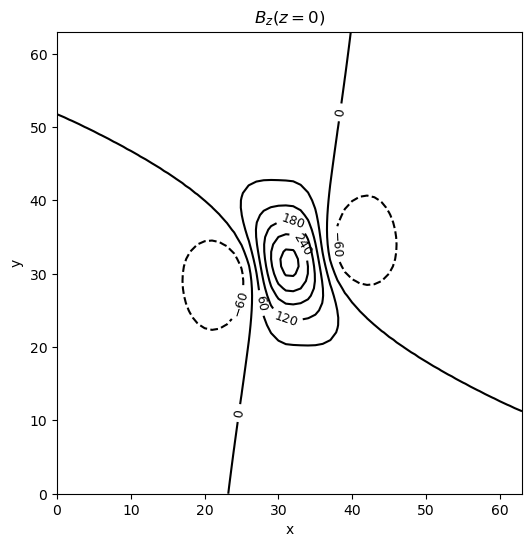

In [ ]:
bpbp.plt_Bz()

In [ ]:
bpbp.pv_streamline()

Widget(value="<iframe src='/proxy/38787/index.html?ui=P_0x7f76303a5e70_0&reconnect=auto' style='width: 99%; he…

In [ ]:
bb = draw_grid(b.grid)

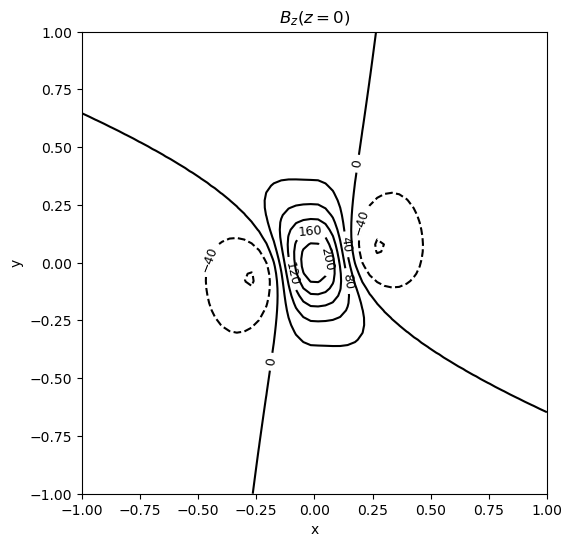

In [ ]:
bb.plt_Bz()

In [ ]:
bb.pv_streamline()

Widget(value="<iframe src='/proxy/38787/index.html?ui=P_0x7f75d02582b0_1&reconnect=auto' style='width: 99%; he…